In [14]:
# =========================
# IMPORTS & GLOBAL SETTINGS
# =========================
import numpy as np
import time
import matplotlib.pyplot as plt

MAX_ITERS = 1000
GRAD_TOL = 1e-6
EPS = 1e-8

# =========================
# OBJECTIVE FUNCTIONS
# =========================

def rosenbrock(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2

def grad_rosenbrock(x, y):
    dx = -2*(1 - x) - 400*x*(y - x**2)
    dy = 200*(y - x**2)
    return np.array([dx, dy])

def sin_inverse(x):
    if abs(x) < 1e-8:
        return 0
    return np.sin(1/x)

def grad_sin_inverse(x):
    if abs(x) < 1e-8:
        return 0
    return -np.cos(1/x)/(x**2)

# =========================
# WRAPPER FUNCTIONS
# =========================

def rosenbrock_fn(params):
    x, y = params
    return rosenbrock(x, y)

def grad_rosenbrock_fn(params):
    x, y = params
    return grad_rosenbrock(x, y)

def sin_inverse_fn(params):
    return sin_inverse(params[0])

def grad_sin_inverse_fn(params):
    return np.array([grad_sin_inverse(params[0])])

# =========================
# ROSENBROCK PROJECTION
# =========================

def project_rosenbrock(params):
    return np.clip(params, -5.0, 5.0)

# =========================
# OPTIMIZERS (FROM SCRATCH)
# =========================

def gradient_descent(grad_fn, init_params, alpha, project_fn=None):
    params = np.array(init_params, dtype=float)
    history = []
    start = time.time()

    for _ in range(MAX_ITERS):
        grad = grad_fn(params)
        if np.linalg.norm(grad) < GRAD_TOL:
            break
        params = params - alpha * grad
        if project_fn:
            params = project_fn(params)
        history.append(params.copy())

    return params, history, time.time() - start


def momentum_gd(grad_fn, init_params, alpha, beta=0.9, project_fn=None):
    params = np.array(init_params, dtype=float)
    velocity = np.zeros_like(params)
    history = []
    start = time.time()

    for _ in range(MAX_ITERS):
        grad = grad_fn(params)
        if np.linalg.norm(grad) < GRAD_TOL:
            break
        velocity = beta * velocity + alpha * grad
        params = params - velocity
        if project_fn:
            params = project_fn(params)
        history.append(params.copy())

    return params, history, time.time() - start


def adagrad(grad_fn, init_params, alpha, project_fn=None):
    params = np.array(init_params, dtype=float)
    G = np.zeros_like(params)
    history = []
    start = time.time()

    for _ in range(MAX_ITERS):
        grad = grad_fn(params)
        if np.linalg.norm(grad) < GRAD_TOL:
            break
        G += grad**2
        params = params - (alpha / (np.sqrt(G) + EPS)) * grad
        if project_fn:
            params = project_fn(params)
        history.append(params.copy())

    return params, history, time.time() - start


def rmsprop(grad_fn, init_params, alpha, beta=0.9, project_fn=None):
    params = np.array(init_params, dtype=float)
    Eg2 = np.zeros_like(params)
    history = []
    start = time.time()

    for _ in range(MAX_ITERS):
        grad = grad_fn(params)
        if np.linalg.norm(grad) < GRAD_TOL:
            break
        Eg2 = beta * Eg2 + (1 - beta) * grad**2
        params = params - (alpha / (np.sqrt(Eg2) + EPS)) * grad
        if project_fn:
            params = project_fn(params)
        history.append(params.copy())

    return params, history, time.time() - start


def adam(grad_fn, init_params, alpha, beta1=0.9, beta2=0.999, project_fn=None):
    params = np.array(init_params, dtype=float)
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    history = []
    start = time.time()

    for t in range(1, MAX_ITERS + 1):
        grad = grad_fn(params)
        if np.linalg.norm(grad) < GRAD_TOL:
            break
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        params = params - alpha * m_hat / (np.sqrt(v_hat) + EPS)
        if project_fn:
            params = project_fn(params)
        history.append(params.copy())

    return params, history, time.time() - start


In [15]:
# =========================
# EXPERIMENT SETUP
# =========================

optimizers = {
    "GD": gradient_descent,
    "Momentum": momentum_gd,
    "Adagrad": adagrad,
    "RMSprop": rmsprop,
    "Adam": adam
}

learning_rates = [0.01, 0.05, 0.1]

# =========================
# ROSENBROCK EXPERIMENTS
# =========================

results_rosen = {}
x0, y0 = -1.5, 1.5

for opt_name, opt_fn in optimizers.items():
    for lr in learning_rates:
        params, history, t = opt_fn(
            grad_rosenbrock_fn,
            init_params=[x0, y0],
            alpha=lr,
            project_fn=project_rosenbrock
        )

        results_rosen[(opt_name, lr)] = {
            "history": [rosenbrock_fn(p) for p in history],
            "final_params": params,
            "final_value": rosenbrock_fn(params),
            "time": t
        }

# =========================
# SIN(1/x) EXPERIMENTS
# =========================

results_sin = {}
x0 = 0.1

for opt_name, opt_fn in optimizers.items():
    for lr in learning_rates:
        params, history, t = opt_fn(
            grad_sin_inverse_fn,
            init_params=[x0],
            alpha=lr
        )

        results_sin[(opt_name, lr)] = {
            "history": [sin_inverse_fn(p) for p in history],
            "final_params": params,
            "final_value": sin_inverse_fn(params),
            "time": t
        }





In [16]:
# =========================
# FINAL RESULTS (PRINT)
# =========================

print("==== ROSENBROCK RESULTS ====")
for k, v in results_rosen.items():
    print(k, "-> x* =", v["final_params"], ", f(x*) =", v["final_value"], ", time =", v["time"])

print("\n==== SIN(1/x) RESULTS ====")
for k, v in results_sin.items():
    print(k, "-> x* =", v["final_params"], ", f(x*) =", v["final_value"], ", time =", v["time"])


==== ROSENBROCK RESULTS ====
('GD', 0.01) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.021755695343017578
('GD', 0.05) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.023131132125854492
('GD', 0.1) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.022324800491333008
('Momentum', 0.01) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.02730846405029297
('Momentum', 0.05) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.029021024703979492
('Momentum', 0.1) -> x* = [-5.  5.] , f(x*) = 40036.0 , time = 0.02588963508605957
('Adagrad', 0.01) -> x* = [-1.29807734  1.69104126] , f(x*) = 5.284803358677846 , time = 0.030443429946899414
('Adagrad', 0.05) -> x* = [-1.20504133  1.45821279] , f(x*) = 4.8659138691113695 , time = 0.029711008071899414
('Adagrad', 0.1) -> x* = [-1.00929581  1.02446373] , f(x*) = 4.0406170846835865 , time = 0.029551029205322266
('RMSprop', 0.01) -> x* = [0.84108029 0.69345656] , f(x*) = 0.04474221908959085 , time = 0.04340815544128418
('RMSprop', 0.05) -> x* = [0.70228107 0.434

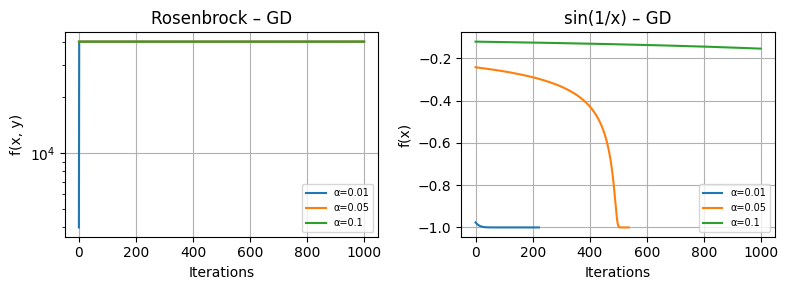

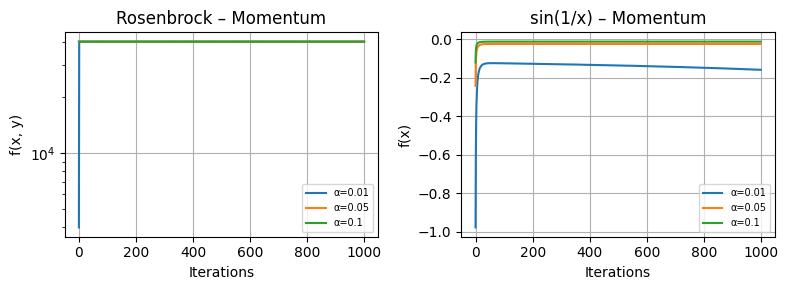

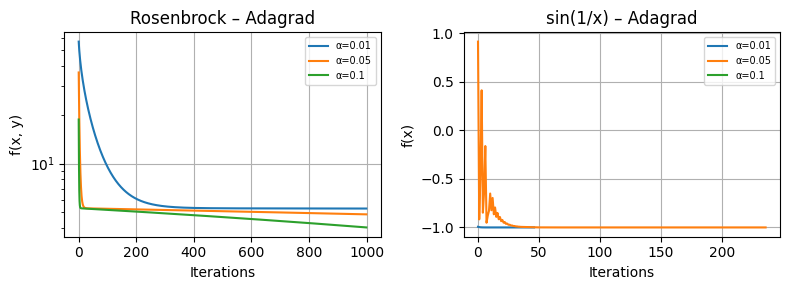

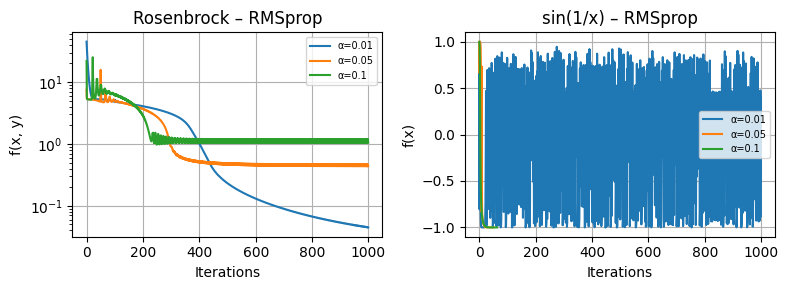

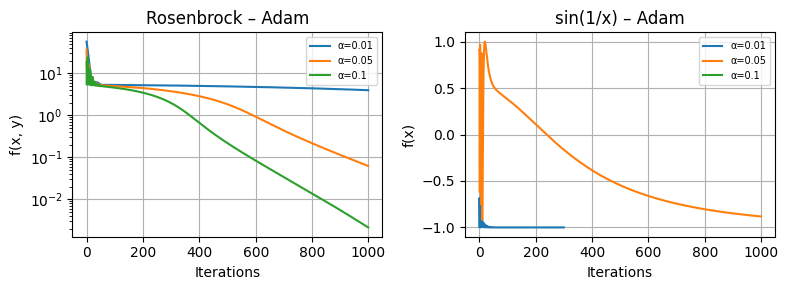

In [17]:
for opt in optimizers:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns

    # -------------------------
    # Rosenbrock (left)
    # -------------------------
    for lr in learning_rates:
        axes[0].plot(
            results_rosen[(opt, lr)]["history"],
            label=f"α={lr}"
        )
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("f(x, y)")
    axes[0].set_title(f"Rosenbrock – {opt}")
    axes[0].grid(True)
    axes[0].legend(fontsize=7)

    # -------------------------
    # sin(1/x) (right)
    # -------------------------
    for lr in learning_rates:
        axes[1].plot(
            results_sin[(opt, lr)]["history"],
            label=f"α={lr}"
        )
    axes[1].set_xlabel("Iterations")
    axes[1].set_ylabel("f(x)")
    axes[1].set_title(f"sin(1/x) – {opt}")
    axes[1].grid(True)
    axes[1].legend(fontsize=7)

    plt.tight_layout()
    plt.show()
